# Triggering the Buy: What Drives Spending, and How Can Pricing Win?

##### Prepared By: Team What a Small World
##### Team Members: Keoh Jun Min, Tan Zin Xuan, Tan Suo Jie, Liew Yee Zhe

## 0. Loading the Data and Required Libraries

In [1]:
# Load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

In [2]:
# Load the dataset
customer = pd.read_csv("G:/My Drive/Data Futures Week Hackathon/Data/customer_conversion.csv")

# Set the index to "ID"
customer.set_index("ID", inplace = True)

## 1. Data Inspection and Preprocessing

### 1.1 Data Inspection

In [3]:
# Shape of the dataset
customer.shape

# Examine the structure of the dataset
customer.info()

# Display the first few rows of the dataset
customer.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4612 entries, EXT001 to EXT4612
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    4612 non-null   int64  
 1   current_occupation     4612 non-null   object 
 2   first_interaction      4612 non-null   object 
 3   profile_completed      4612 non-null   object 
 4   website_visits         4612 non-null   int64  
 5   time_spent_on_website  4612 non-null   int64  
 6   page_views_per_visit   4612 non-null   float64
 7   last_activity          4612 non-null   object 
 8   print_media_type1      4612 non-null   object 
 9   print_media_type2      4612 non-null   object 
 10  digital_media          4612 non-null   object 
 11  educational_channels   4612 non-null   object 
 12  referral               4612 non-null   object 
 13  status                 4612 non-null   int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 540.

,age,current_occupation,first_interaction,profile_completed,website_visits,time_spent_on_website,page_views_per_visit,last_activity,print_media_type1,print_media_type2,digital_media,educational_channels,referral,status
ID,,,,,,,,,,,,,,
EXT001,57,Unemployed,Website,High,7,1639,1.861,Website Activity,Yes,No,Yes,No,No,1
EXT002,56,Professional,Mobile App,Medium,2,83,0.320,Website Activity,No,No,No,Yes,No,0
EXT003,52,Professional,Website,Medium,3,330,0.074,Website Activity,No,No,Yes,No,No,0
EXT004,53,Unemployed,Website,High,4,464,2.057,Website Activity,No,No,No,No,No,1
EXT005,23,Student,Website,High,4,600,16.914,Email Activity,No,No,No,No,No,0


### 1.2 Missing Values

In [4]:
# Check for missing values
customer.isnull().sum()

age                      0
current_occupation       0
first_interaction        0
profile_completed        0
website_visits           0
time_spent_on_website    0
page_views_per_visit     0
last_activity            0
print_media_type1        0
print_media_type2        0
digital_media            0
educational_channels     0
referral                 0
status                   0
dtype: int64

### 1.3 Abnormal Values

In [5]:
# Check for abnormal numeric values
customer.describe()

,age,website_visits,time_spent_on_website,page_views_per_visit,status
count,4612.000000,4612.000000,4612.000000,4612.000000,4612.000000
mean,46.201214,3.566782,724.011275,3.026126,0.298569
std,13.161454,2.829134,743.828683,1.968125,0.457680
min,18.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,2.000000,148.750000,2.077750,0.000000
50%,51.000000,3.000000,376.000000,2.792000,0.000000
75%,57.000000,5.000000,1336.750000,3.756250,1.000000
max,63.000000,30.000000,2537.000000,18.434000,1.000000


In [6]:
# Check for abnornal categorical values
print(customer["current_occupation"].value_counts())
print(customer["first_interaction"].value_counts())
print(customer["profile_completed"].value_counts())
print(customer["last_activity"].value_counts())

current_occupation
Professional    2616
Unemployed      1441
Student          555
Name: count, dtype: int64
first_interaction
Website       2542
Mobile App    2070
Name: count, dtype: int64
profile_completed
High      2264
Medium    2241
Low        107
Name: count, dtype: int64
last_activity
Email Activity      2278
Phone Activity      1234
Website Activity    1100
Name: count, dtype: int64


### 1.4 (Low/High) Cardinality

In [7]:
# Check for cardinality of categorical variables
print(customer["current_occupation"].nunique())
print(customer["first_interaction"].nunique())
print(customer["profile_completed"].nunique())
print(customer["last_activity"].nunique())

3
2
3
3


### 1.5 Multicollinearity

<Axes: >

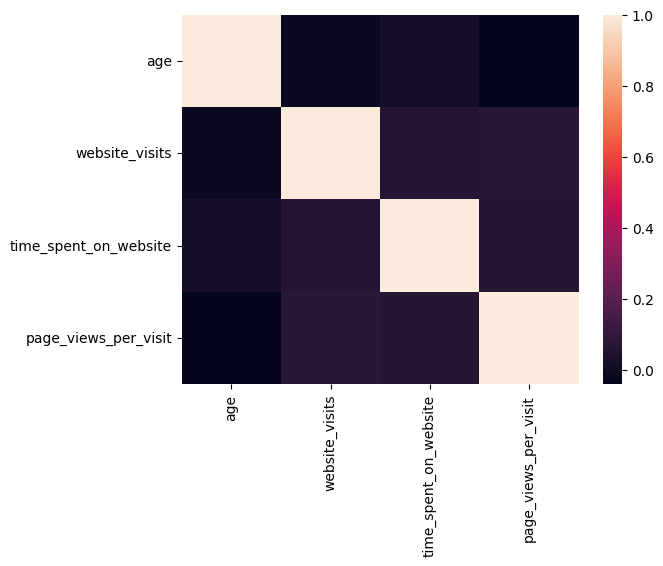

In [8]:
# Check for multicollinearity
correlation_matrix = customer.select_dtypes(include = "number").drop(columns = "status").corr()
sns.heatmap(correlation_matrix)

### 1.6 Class Imbalance

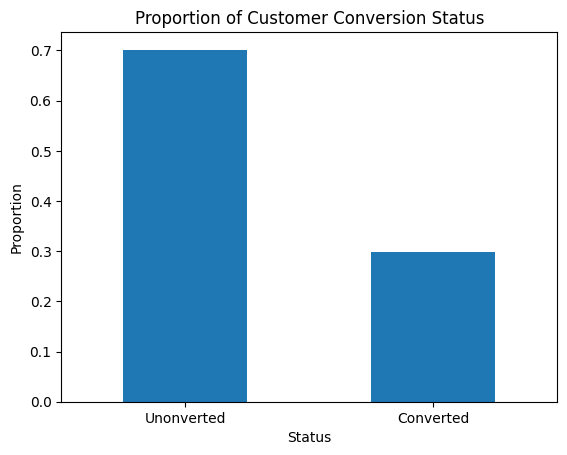

In [9]:
# Class imbalance
customer["status"].value_counts(normalize = True).plot(kind = "bar")
plt.xlabel("Status")
plt.ylabel("Proportion")
plt.title("Proportion of Customer Conversion Status")
plt.xticks(rotation = 0, ticks = [0, 1], labels = ["Unonverted", "Converted"]);

## 2. Exploratory Data Analysis (EDA)

### 2.1 Customer Conversion by Occupation

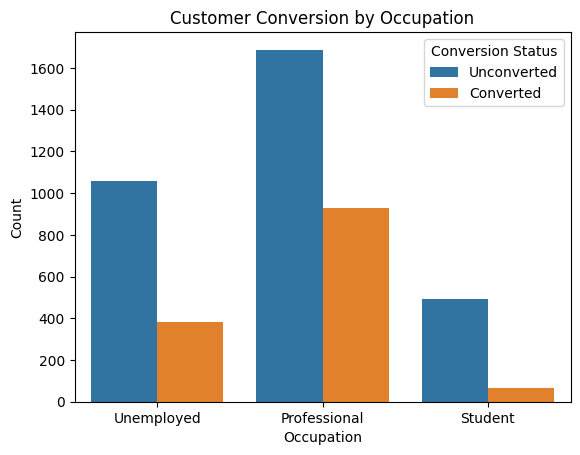

In [10]:
# Stacked bar chart of customer conversion by occupation
sns.countplot(
    data = customer,
    x = "current_occupation",
    hue = "status",
    palette = ["#1f77b4", "#ff7f0e"],
)
plt.title("Customer Conversion by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Count")
plt.legend(
    title = "Conversion Status", 
    labels = ["Unconverted", "Converted"], 
    bbox_to_anchor = (1.00, 1), 
    loc = "best"
);

# save plot to outputs folder with dpi 300
plt.savefig("outputs/customer_conversion_by_occupation.png", dpi = 300, bbox_inches = "tight")

### 2.2 Distribution of Age by Conversion Status

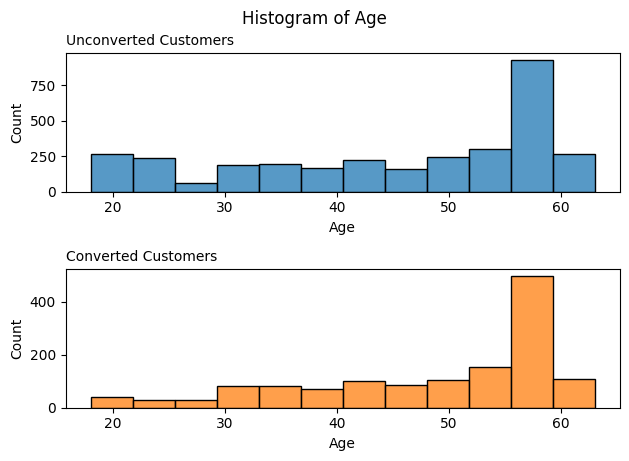

In [11]:
# Histograms of age by customer conversion status
fig, axes = plt.subplots(2, 1)
fig.suptitle("Histogram of Age", y=0.95)

sns.histplot(
    data=customer[customer["status"] == 0],
    x="age",
    color="#1f77b4",
    bins=12,
    ax=axes[0]
)
sns.histplot(
    data=customer[customer["status"] == 1],
    x="age",
    color="#ff7f0e",
    bins=12,
    ax=axes[1]
)

axes[0].set_title("Unconverted Customers", loc = "left", fontsize = 10)
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")

axes[1].set_title("Converted Customers", loc = "left", fontsize = 10)
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Count")

plt.tight_layout();

# save plot to outputs folder with dpi 300
plt.savefig("outputs/histogram_age.png", dpi = 300, bbox_inches = "tight")

### 2.3 Last Engagement Channel by Conversion Status

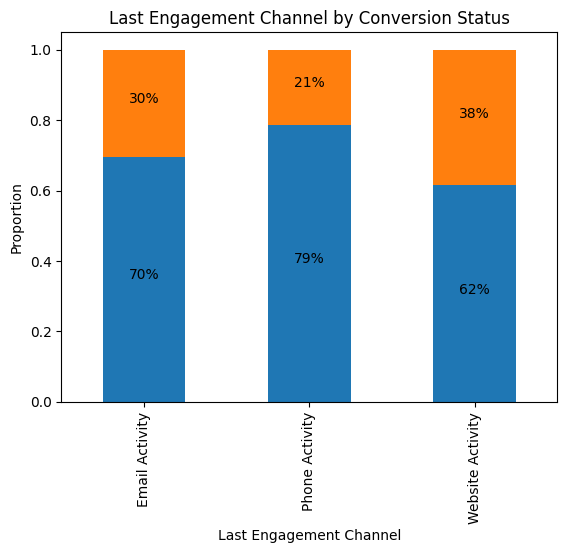

In [12]:
# Proportion of last activity channel by conversion status
activity_counts = (
    customer.groupby(["last_activity", "status"])
    .size()
    .unstack()
    .apply(lambda x: x / x.sum(), axis = 1)
)

# Stacked bar chart
ax = activity_counts.plot(kind = "bar", stacked = True, color = ["#1f77b4", "#ff7f0e"])
plt.title("Last Engagement Channel by Conversion Status")
plt.xlabel("Last Engagement Channel")
plt.ylabel("Proportion")
plt.xticks()

# Add percentage labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(
        f"{height:.0%}", 
        (x + width / 2, y + height / 2), 
        ha = "center"
    )
    
plt.legend().remove();

# save plot to outputs folder with dpi 300
plt.savefig("outputs/last_engagement_channel_by_conversion_status.png", dpi = 300, bbox_inches = "tight")

### 2.4 Website Engagement Time by Conversion Status

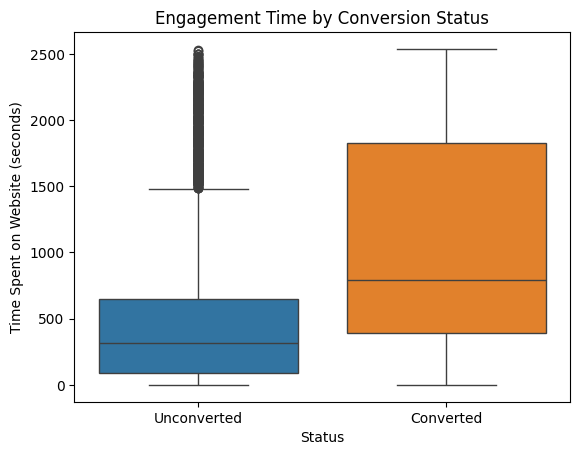

In [13]:
# Boxplot for website engagement time by conversion status
sns.boxplot(
    data = customer,
    x = "status",
    y = "time_spent_on_website",
    hue = "status",
    palette = ["#1f77b4", "#ff7f0e"]
)
plt.title("Engagement Time by Conversion Status")
plt.xlabel("Status")
plt.ylabel("Time Spent on Website (seconds)")
plt.legend().remove()
plt.xticks([0, 1], ["Unconverted", "Converted"]);

## 3. Customer Segmentation Analysis

### 3.1 Cluster Analysis

In [14]:
# Select features for clustering
X_cluster = customer[["time_spent_on_website", "website_visits", "page_views_per_visit"]]

# Scale the features
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Cluster analysis
n_clusters = range(2, 11, 1)
inertia = []
silhouette_scores = []

for n in n_clusters:
    kmeans = KMeans(n_clusters = n, random_state = 42)
    kmeans.fit(X_cluster_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# Convert the inertia and silhouette scores to DataFrames
inertia_df = pd.DataFrame({"n_clusters": n_clusters, "inertia": inertia})
silhouette_df = pd.DataFrame({"n_clusters": n_clusters, "silhouette_score": silhouette_scores})

### 3.2 Elbow Method

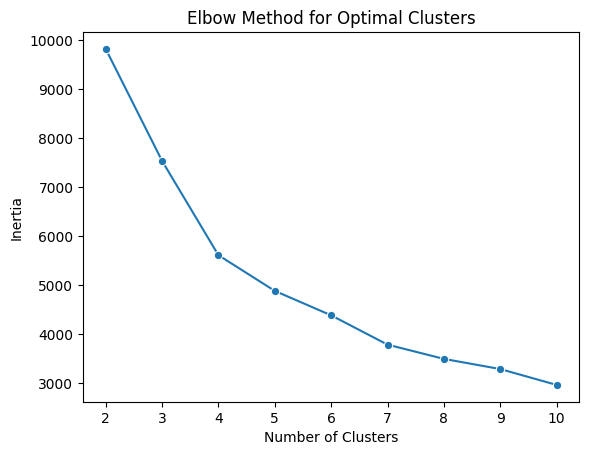

In [ ]:
# Plot the elbow method
sns.lineplot(x = "n_clusters", y = "inertia", data = inertia_df, marker = "o")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Clusters");

### 3.3 Silhouette Method

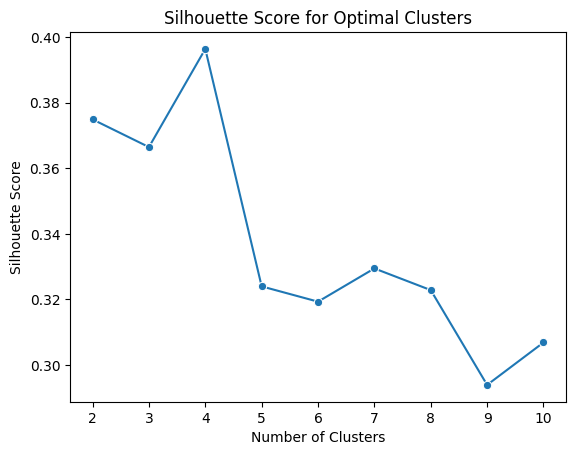

In [ ]:
# Plot the silhouette scores
sns.lineplot(x = "n_clusters", y = "silhouette_score", data = silhouette_df, marker = "o")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal Clusters");

### 3.4 Final K-Means Model with the Optimal Number of Clusters

In [19]:
# Build the final KMeans model with four clusters
final_kmeans = KMeans(n_clusters = 4, random_state = 42)
final_kmeans.fit(X_cluster_scaled)

# Add the cluster labels to the original dataset
customer_segmented = customer.copy()
customer_segmented["cluster"] = final_kmeans.labels_

# Calculate the inertia and silhouette score for the final k-means model
inertia_final = final_kmeans.inertia_
silhouette_final = silhouette_score(X_cluster_scaled, final_kmeans.labels_)

print(f"Inertia: {inertia_final}")
print(f"Silhouette Score: {silhouette_final}")

Inertia: 5615.79725801858
Silhouette Score: 0.3964061324544142


### 3.5 Distribution of Clusters

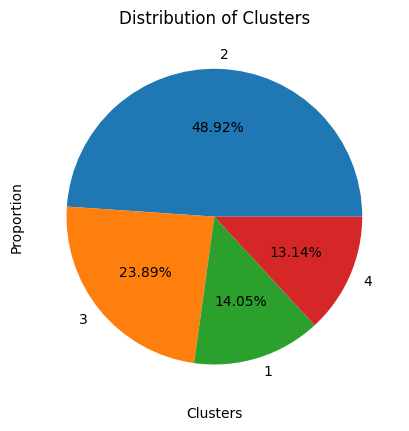

In [21]:
# Pie chart of clusters
plt.pie(customer_segmented["cluster"].value_counts(), labels = customer_segmented["cluster"].value_counts().index + 1, autopct = "%1.2f%%")
plt.xlabel("Clusters")
plt.ylabel("Proportion")
plt.title("Distribution of Clusters");

### 3.6 Customer Conversation Status within Clusters

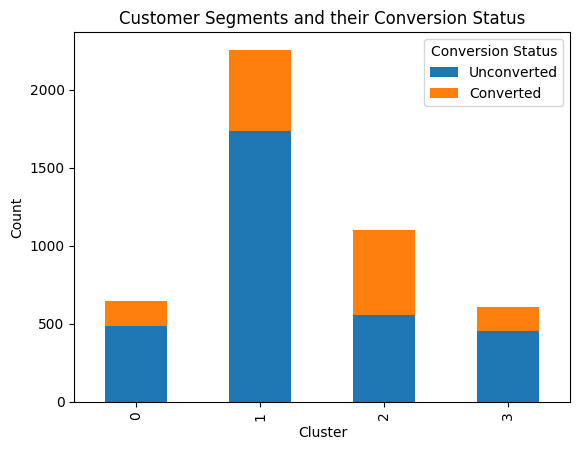

In [ ]:
# Bar plot of clusters from clusters with their conversion status
customer_segmented.groupby(["cluster", "status"]).size().unstack().plot(kind = "bar", stacked = True)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title = "Conversion Status", labels = ["Unconverted", "Converted"])
plt.title("Customer Segments and their Conversion Status");

### 3.7 Cluster Summary

In [ ]:
# Summary of customer segments
customer_segmented_summary = customer_segmented.groupby("cluster").agg(
    {
        "time_spent_on_website": ["mean"],
        "website_visits": ["mean"],
        "page_views_per_visit": ["mean"],
        "status": lambda x: x.sum() / customer["status"].sum(),
    }
).reset_index()
customer_segmented_summary.columns = ["Cluster", "Average Time Spent on Website", "Average Website Visits", "Average Page Views per Visit", "Proportion of Converted Customers"]

# Round the values to 2 decimal places
customer_segmented_summary["Average Time Spent on Website"] = customer_segmented_summary["Average Time Spent on Website"].round(2)
customer_segmented_summary["Average Website Visits"] = customer_segmented_summary["Average Website Visits"].round(2)
customer_segmented_summary["Average Page Views per Visit"] = customer_segmented_summary["Average Page Views per Visit"].round(2)
customer_segmented_summary["Proportion of Converted Customers"] = customer_segmented_summary["Proportion of Converted Customers"].round(2)

# Display the summary DataFrame
customer_segmented_summary


## 4. Feature Engineering

### 4.1 One Hot Encoding

In [ ]:
# Separate features that need to be encoded
categorical_features = ["current_occupation", "first_interaction", "profile_completed", "last_activity"]
other_features = [col for col in customer.columns if col not in categorical_features + ["status"]]

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse_output = False, drop = None)

# Perform one-hot encoding on the categorical features
customer_ohe = pd.DataFrame(
    ohe.fit_transform(customer[categorical_features]).astype(int),
    columns = ohe.get_feature_names_out(categorical_features),
    index = customer.index
)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
customer_encoded = pd.concat([
    customer[other_features],
    customer_ohe
], axis = 1)

### 4.2 Label Encoding

In [ ]:
# Label encoding
customer_encoded["print_media_type1"] = np.where(customer_encoded["print_media_type1"] == 'Yes', 1, 0)
customer_encoded["print_media_type2"] = np.where(customer_encoded["print_media_type2"] == 'Yes', 1, 0)
customer_encoded["digital_media"] = np.where(customer_encoded["digital_media"] == 'Yes', 1, 0)
customer_encoded["educational_channels"] = np.where(customer_encoded["educational_channels"] == 'Yes', 1, 0)
customer_encoded["referral"] = np.where(customer_encoded["referral"] == 'Yes', 1, 0)

# Display the first few rows of the encoded DataFrame
customer_encoded.head()


## 5. Predictive Model Development and Selection

### 5.1 Train-Test Split

In [ ]:
# Target vector
y = customer["status"]

# Feature matrix
X = customer_encoded

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Shape of the training and test sets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

### 5.2 Logistic Regression

In [ ]:
# Instantiate the Logistic Regression model
log_reg = LogisticRegression(max_iter = 10000, random_state = 42)

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_log_reg = log_reg.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_log_reg))

In [ ]:
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings("ignore", category = UserWarning)

# Hyperparameter tuning
penalty = ["l1", "l2", None]
C = [0.01, 0.1, 1, 10, 100]
solver = ["liblinear", "lbfgs"]
max_iter = [100, 1000, 10000]

# Initialize an empty list to store the results
results = []

# Loop through the hyperparameters
for p in penalty:
    for c in C:
        for s in solver:
            for m in max_iter:
                try:
                    # Instantiate the Logistic Regression model with the current hyperparameters
                    log_reg = LogisticRegression(penalty = p, C = c, solver = s, max_iter = m, random_state = 42)

                    # Fit the model to the training data
                    log_reg.fit(X_train, y_train)

                    # Make predictions on the test set
                    y_pred = log_reg.predict(X_test)

                    # Calculate accuracy
                    accuracy = accuracy_score(y_test, y_pred)

                    # Append the results to the list
                    results.append((p, c, s, m, accuracy))

                except Exception as e:
                    # Handle cases where the combination of hyperparameters is invalid
                    results.append((p, c, s, m, None))

In [ ]:
# Convert the results to a DataFrame
log_reg_tuned_results = pd.DataFrame(results, columns = ["Penalty", "C", "Solver", "Max Iter", "Accuracy"])

# Display the results DataFrame
log_reg_tuned_results["Accuracy"] = log_reg_tuned_results["Accuracy"].round(4)
log_reg_tuned_results.sort_values(by = "Accuracy", ascending = False).head(10)

# Select the best hyperparameters
best_log_reg_hyperparameters = log_reg_tuned_results.loc[log_reg_tuned_results["Accuracy"].idxmax()]
print(f"Best Hyperparameters: {best_log_reg_hyperparameters['Penalty']}, {best_log_reg_hyperparameters['C']}, {best_log_reg_hyperparameters['Solver']}, {best_log_reg_hyperparameters['Max Iter']}")

In [ ]:
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings("ignore", category = UserWarning)

# Build the final Logistic Regression model with the best hyperparameters
log_reg_final = LogisticRegression(
    penalty = best_log_reg_hyperparameters["Penalty"],
    C = best_log_reg_hyperparameters["C"],
    solver = best_log_reg_hyperparameters["Solver"],
    max_iter = best_log_reg_hyperparameters["Max Iter"],
    random_state = 42
)

# Fit the final model to the training data
log_reg_final.fit(X_train, y_train)

# Make predictions on the test set
y_pred_log_reg_final = log_reg_final.predict(X_test)

# Classification report for the final model
print(classification_report(y_test, y_pred_log_reg_final))

# Confusion matrix for the final model
conf_matrix = confusion_matrix(y_test, y_pred_log_reg_final)
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Final Logistic Regression Model");

### 5.3 Decision Tree

In [ ]:
# Instantiate the Decision Tree Classifier model
dt_classifier = DecisionTreeClassifier(random_state = 42)

# Fit the model to the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = dt_classifier.predict(X_test)

# Classification report for the Decision Tree Classifier
print(classification_report(y_test, y_pred_dt))

In [ ]:
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings("ignore", category = UserWarning)

# Hyperparameter tuning
criterion = ["gini", "entropy"]
max_depth = [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
max_features = [None, "sqrt", "log2"]

# Initialize an empty list to store the results
results = []

# Loop through the hyperparameters
for c in criterion:
    for d in max_depth:
        for f in max_features:
            try:
                # Instantiate the Decision Tree Classifier model with the current hyperparameters
                dt_classifier = DecisionTreeClassifier(criterion = c, max_depth = d, max_features = f, random_state = 42)

                # Fit the model to the training data
                dt_classifier.fit(X_train, y_train)

                # Make predictions on the test set
                y_pred = dt_classifier.predict(X_test)

                # Calculate accuracy
                accuracy = accuracy_score(y_test, y_pred)

                # Append the results to the list
                results.append((c, d, f, accuracy))

            except Exception as e:
                # Handle cases where the combination of hyperparameters is invalid
                results.append((c, d, f, None))

In [ ]:
# Convert results to a DataFrame
dt_tuned_results = pd.DataFrame(results, columns=["Criterion", "Max Depth", "Max Features", "Accuracy"])

# Display the results DataFrame
dt_tuned_results["Accuracy"] = dt_tuned_results["Accuracy"].round(4)
dt_tuned_results.sort_values(by = "Accuracy", ascending = False).head(10)

# Select the best hyperparameters
best_dt_hyperparameters = dt_tuned_results.loc[dt_tuned_results["Accuracy"].idxmax()]
print(f"Best Hyperparameters: {best_dt_hyperparameters['Criterion']}, {best_dt_hyperparameters['Max Depth']}, {best_dt_hyperparameters['Max Features']}")

In [ ]:
# Build the final Decision Tree Classifier model with the best hyperparameters
dt_classifier_final = DecisionTreeClassifier(
    criterion = best_dt_hyperparameters["Criterion"],
    max_depth = best_dt_hyperparameters["Max Depth"].astype(int),
    max_features = best_dt_hyperparameters["Max Features"],
    random_state = 42
)

# Fit the final model to the training data
dt_classifier_final.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt_final = dt_classifier_final.predict(X_test)

# Classification report for the final model
print(classification_report(y_test, y_pred_dt_final))

# Confusion matrix for the final model
conf_matrix = confusion_matrix(y_test, y_pred_dt_final)
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False) 
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Final Decision Tree Model");

### 5.4 Gradient Boosting

In [ ]:
# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Set up parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model and evaluation
print("Best Hyperparameters:", grid_search.best_params_)

best_gb_model = grid_search.best_estimator_
y_pred_best = best_gb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_best)
print(f"Fine-Tuned Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_best))

In [ ]:
# Print the confusion matrix
print(classification_report(y_test, y_pred_best))
conf_matrix = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Final Gradient Boosting Model")
plt.show()

### 5.5 XGBoost

In [ ]:
# Instantiate and fit the XGBoost Classifier model
xgb_model = XGBClassifier(eval_metric = "logloss")
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Accuracy and classification report for the XGBoost Classifier
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0]
}

# Instantiate the XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric = "logloss")

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator = xgb_clf,
    param_grid = param_grid,
    scoring = "accuracy",
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
grid_search.fit(X_train, y_train)

# Convert the grid search results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns and rename for clarity
xgb_tuned_results = results_df[[
    "param_n_estimators", "param_max_depth", "param_learning_rate",
    "param_subsample", "mean_test_score"
]].copy()
xgb_tuned_results.columns = ["N Estimators", "Max Depth", "Learning Rate", "Subsample", "Accuracy"]
xgb_tuned_results["Accuracy"] = xgb_tuned_results["Accuracy"].round(4)

# Identify the best hyperparameters
best_xgb_hyperparams = xgb_tuned_results.loc[xgb_tuned_results["Accuracy"].idxmax()]
print(f"Best Hyperparameters:\n{best_xgb_hyperparams}")

In [ ]:
# Build the final XGBoost model with the best hyperparameters
best_model = XGBClassifier(
    n_estimators = int(best_xgb_hyperparams["N Estimators"]),
    max_depth = int(best_xgb_hyperparams["Max Depth"]),
    learning_rate = float(best_xgb_hyperparams["Learning Rate"]),
    subsample = float(best_xgb_hyperparams["Subsample"]),
    eval_metric = "logloss",
    random_state = 42
)

# Fit the model to the training data
best_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_final = best_model.predict(X_test)

# Accuracy and classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_final))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize = (6, 4))
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Final XGBoost Model");
plt.show()

### 5.6 Random Forest

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report for more detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
warnings.filterwarnings("ignore", category = ConvergenceWarning)
warnings.filterwarnings("ignore", category = UserWarning)

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of fine-tuned model: {accuracy:.4f}")

# Print classification report for more detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix for the final model
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Final Random Forest Model")
plt.show()

## 6. Predictive Model Evaluation

### 6.1 Feature Importances

In [ ]:
# Feature importances
importances = best_model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index = feature_names)

# Plot feature importances
feat_imp.sort_values().head(10).plot(kind = "barh")
plt.title("Top 10 Feature Importances")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names");

### 6.2 Champion Model Evaluation

In [ ]:
# Print accuracy score for the champion model
print(f"Champion Model Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")

# Get classification report as a dictionary
report = classification_report(y_test, y_pred_final, output_dict=True)

# Print recall score for the champion model
print(f"Champion Model Recall: {report['1']['recall']:.4f}")

# Print precision score for the champion model
print(f"Champion Model Precision: {report['1']['precision']:.4f}")

# Print confusion matrix for the champion model
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "Blues", cbar = False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Champion Model")
plt.show();